In [1]:
import numpy as np
import os, sys
import lalsimulation as lalsim
import lal
from scipy.interpolate import interp1d

%matplotlib inline
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

sys.path.append('../../../..')
import MonashGWTools.waveforms as wv
import MonashGWTools.tools as tools

/cvmfs/oasis.opensciencegrid.org/ligo/sw/pycbc/x86_64_rhel_7/virtualenv/pycbc-v1.8.0/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def snr_matchedfilter(hf, muf, f, Sh):
    '''                                                                                                            
    eric.thrane@ligo.org                                                                                           
    calculate matched filter SNR for template muf given data hf                                                    
    '''
    snr = tools.inner_product(hf, muf, f, Sh) / np.sqrt(tools.inner_product(muf, muf, f, Sh))
    return snr

In [3]:
def gen_waveform(phiRef, deltaF, m1, m2, fmin, fmax, iota, dist, inc_azim, e_min):

    fref = 10.
    m1 *= lal.lal.MSUN_SI
    m2 *= lal.lal.MSUN_SI
    dist = 1e6*lal.lal.PC_SI*dist
    phaseO = -1
    
    approx = lalsim.GetApproximantFromString("EccentricFD")
    meanPerAno = 0
    longAscNodes = 0
    
    WFdict = lal.CreateDict()
    
    #H = lalsim.SimInspiralFD(phiRef, deltaF, m1, m2, fmin, fmax, iota, dist, inc_azim, e_min, phaseO)
    H = lalsim.SimInspiralChooseFDWaveform(m1, m2, 0, 0, 0, 0, 0, 0, dist, iota, phiRef, longAscNodes, e_min, meanPerAno, deltaF, fmin, fmax, fref, WFdict, approx)
    hplus = H[0].data.data
    hcross = H[1].data.data

    
    
    return hplus, hcross



#/bin/lalsim-inspiral -P -a EccentricFD -O -1 -u 0 -f 10 -e 0.1 -R 1024. -m1 35 -m2 30 -i 0 -d 400

In [4]:
def detector_strain(h_p, h_c, RA, DEC, psi, epoch):
    
    tgps = lal.LIGOTimeGPS(epoch)
    gmst = lal.GreenwichMeanSiderealTime(tgps)
    
    # Antenna response:
    fplus, fcross = wv.AntennaResponse(RA, DEC, psi, epoch, ifo='H1')
    diff = lal.LALDetectorIndexLHODIFF
    
    timedelay = lal.TimeDelayFromEarthCenter(lal.CachedDetectors[diff].location, RA, DEC, tgps)
    timeshift = epoch + timedelay
    
    #Calculate the observed strain at the detector, properly shifting the waveform from geocenter to detector frame.
    h = np.zeros_like(h_p, dtype=complex)
    pit = np.pi*timeshift
    if timeshift != 0.0:
        shift = complex(1.0, 0)
        dshift = complex(-2.*np.sin(pit*deltaF)*np.sin(pit*deltaF), -2.*np.sin(pit*deltaF)*np.cos(pit*deltaF))
        for i in xrange(0,h_p.size):
            h[i] = shift*(fplus*h_p[i] + fcross*h_c[i])
            shift += shift*dshift
    else: h = (fplus*h_p) + (fcroh_c)
        
    return h


In [26]:
phiRef = 0.
fmin = 10.
fmax = 1024.
deltaF = 1./8.
Fsh = 2*fmax
m1 = 40.
m2 = 35.
dist = 300.
iota = 90.
inc_azim = 0.
e_min = 0.4

RA = 20.9375
DEC = 45.
psi = 0.

epoch = 1000000004

In [27]:
hplus,hcross = gen_waveform(phiRef, deltaF, m1, m2, fmin, fmax, iota, dist, inc_azim, e_min)

htilde = detector_strain(hplus, hcross, RA, DEC, psi, epoch)

q_t = tools.infft(htilde,Fsh)

In [28]:
ff = np.linspace(0,fmax,len(htilde))

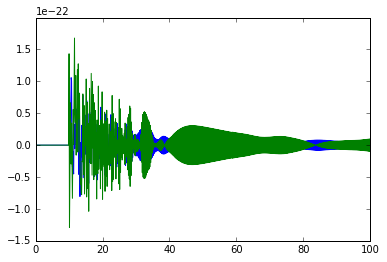

In [29]:
plt.plot(ff,htilde)
plt.plot(ff1,htilde1)
plt.xlim(0,100)
plt.show()

In [8]:
data_file = np.loadtxt('injections/injection.dat')
data = data_file[:,1]
Fs = 1/(data_file[1,0].real - data_file[0,0].real)

FFTdata, freq = tools.nfft(data,Fs)

noise_file = np.loadtxt('injections/noise.dat')
noise = noise_file[:,1]

PSD_file = np.column_stack( np.loadtxt("../../../../MonashGWTools/NoiseCurves/aLIGO_ZERO_DET_high_P_asd.txt") )
PSD_interp_funct = interp1d(PSD_file[0,:], PSD_file[1,:], bounds_error=False, fill_value=np.inf)
PSD = PSD_interp_funct(freq)

divData = FFTdata/np.sqrt(PSD)

whitened_data = tools.infft(divData,Fs)

plt.plot(data_file[:,0],whitened_data)
plt.axvline(4.2+1e9,color='r')
plt.axvline(2.2+1e9,color='r')
plt.ylim(-0.5e-9,0.5e-9)
plt.xlabel('time')
plt.ylabel('strain')
plt.tight_layout()
plt.savefig('whitened_strain.png',dpi=200)
plt.show()

IOError: [Errno 2] No such file or directory: 'injections/injection.dat'

In [9]:
Fsn = 1/(noise_file[1,0].real - noise_file[0,0].real)
FFTnoise, nfreq = tools.nfft(noise,Fsn)

divNoise = FFTnoise/np.sqrt(PSD)

whitened_noise = tools.infft(divNoise,Fsn)

plt.hist(whitened_noise,bins=100)
plt.title('Binned whitened noise')
plt.xlabel('strain')
plt.ylabel('histogram counts')
plt.tight_layout()
plt.savefig('binned_noise.png',dpi=200)
plt.show()

NameError: name 'noise_file' is not defined

In [10]:
tools.snr_exp(FFTdata,freq,PSD_file)

NameError: name 'FFTdata' is not defined

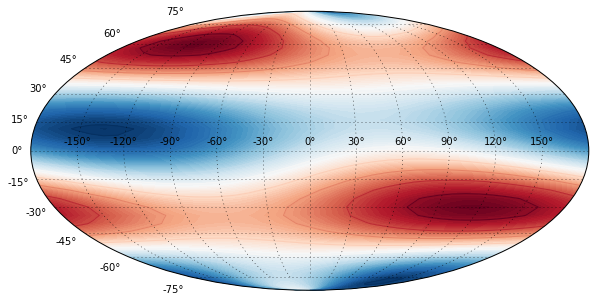

In [28]:
ra = np.linspace(-np.pi, np.pi, 40)
dec= np.linspace(-np.pi/2, np.pi/2, 40)

Fp = np.zeros((len(ra),len(dec)))
Fc = np.zeros((len(ra),len(dec)))

for i in range(0,len(ra)):
    for k in range(0,len(dec)):
        Fp[i,k], Fc[i,k] = wv.AntennaResponse(ra[i], dec[k], 0, 1000000000, ifo='H1')

X,Y = np.meshgrid(ra,dec)

H1 = Fp + Fc

plt.figure(1,(10,10))
ax = plt.subplot(111, projection = 'mollweide')
ax.contourf(X,Y,Fp,100,cmap='RdBu')
ax.contour(X,Y,Fp,10,cmap='RdBu')
ax.grid()

plt.show(1)

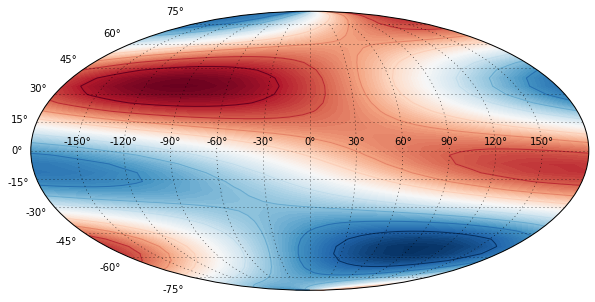

In [29]:
plt.figure(1,(10,10))
ax = plt.subplot(111, projection = 'mollweide')
ax.contourf(X,Y,Fc,100,cmap='RdBu')
ax.contour(X,Y,Fc,10,cmap='RdBu')
ax.grid()
plt.show(1)

In [6]:
import pickle
with open('./samples/posteriors_DO_NOT_REMOVE_.pickle', 'rb') as handle:
    posteriors = pickle.load(handle)

In [3]:
import emcee
from emcee import PTSampler

PTSampler?

In [2]:
ntemps = 16
nwalkers = 500
ndim = 7
nsteps = 2000

m1_min, m1_max = 5, 50
m2_min, m2_max = 5, 50
ecc_min, ecc_max = np.log10(0.1),np.log10(0.5)
angle_min, angle_max = 0., np.pi*2.
dist_min, dist_max = 50, 3000.
    
m1 = np.random.uniform(low=(m1_min+5), high=m1_max, size=(ntemps*nwalkers, 1))
m2 =  np.random.uniform(low=m2_min, high=m2_max, size=(ntemps*nwalkers, 1))

e_min = np.random.uniform(low=ecc_min, high=ecc_max, size=(ntemps*nwalkers, 1))
    
dist = np.random.uniform(low=dist_min, high=dist_max, size=(ntemps*nwalkers, 1))
iota = np.random.uniform(low=angle_min, high=angle_max, size=(ntemps*nwalkers, 1))
RA = np.random.uniform(low=angle_min, high=angle_max, size=(ntemps*nwalkers, 1))
DEC = np.random.uniform(low=angle_min, high=angle_max, size=(ntemps*nwalkers, 1))

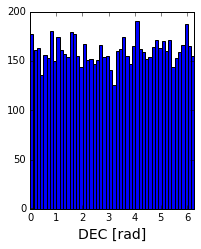

In [3]:
fig = plt.figure(1,(10,12))
# ax1 = fig.add_subplot(331)
# ax1.hist(m1,bins=50)
# ax1.set_xlabel('m1',fontsize=14)
# ax2 = fig.add_subplot(332)
# ax2.hist(m2,bins=50)
# ax2.set_xlabel('m2',fontsize=14)
# ax3 = fig.add_subplot(333)
# ax3.hist(e_min,bins=50)
# ax3.set_xlabel(r'log$_{10}$(e)',fontsize=14)
# ax4 = fig.add_subplot(334)
# ax4.hist(dist,bins=50)
# ax4.set_xlabel('distance',fontsize=14)
# ax5 = fig.add_subplot(335)
# ax5.hist(iota,bins=50)
# ax5.set_xlim(0,6.28)
# ax5.set_xlabel(r'$\iota$ [rad]',fontsize=14)
# ax6 = fig.add_subplot(336)
# ax6.hist(RA,bins=50)
# ax6.set_xlim(0,6.28)
# ax6.set_xlabel('RA [rad]',fontsize=14)
ax7 = fig.add_subplot(331)
ax7.hist(DEC,bins=50)
ax7.set_xlim(0,6.28)
ax7.set_xlabel('DEC [rad]',fontsize=14)
plt.savefig('p_DEC.png',dpi=200)
plt.show(1)

In [4]:
np.shape(posteriors)

NameError: name 'posteriors' is not defined

In [7]:
from itertools import chain
flat_p = list(chain(*posteriors))
np.shape(flat_p)

(8000, 7)

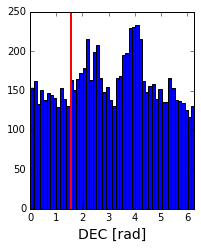

In [63]:
stack_p = np.vstack(flat_p)
truths=[35.,30.,np.log10(0.1),410.,(0.*np.pi/180),(90*np.pi/180.),(90.*np.pi/180.)]

fig = plt.figure(1,(10,12))
# ax1 = fig.add_subplot(331)
# ax1.hist(stack_p[:,0],bins=50)
# ax1.axvline(truths[0],lw=2,color='r')
# ax1.set_xlabel('m1',fontsize=14)
# ax2 = fig.add_subplot(332)
# ax2.hist(stack_p[:,1],bins=50)
# ax2.axvline(truths[1],lw=2,color='r')
# ax2.set_xlabel('m2',fontsize=14)
# ax3 = fig.add_subplot(333)
# ax3.hist(stack_p[:,2],bins=50)
# ax3.axvline(truths[2],lw=2,color='r')
# ax3.set_xlabel(r'log$_{10}$(e)',fontsize=14)
# ax4 = fig.add_subplot(334)
# ax4.hist(stack_p[:,3],bins=50)
# ax4.axvline(truths[3],lw=2,color='r')
# ax4.set_xlabel('distance',fontsize=14)
# ax5 = fig.add_subplot(335)
# ax5.hist(stack_p[:,4],bins=50)
# ax5.axvline(truths[4],lw=2,color='r')
# ax5.set_xlim(0,6.28)
# ax5.set_xlabel(r'$\iota$ [rad]',fontsize=14)
# ax6 = fig.add_subplot(336)
# ax6.hist(stack_p[:,5],bins=50)
# ax6.axvline(truths[5],lw=2,color='r')
# ax6.set_xlim(0,6.28)
# ax6.set_xlabel('RA [rad]',fontsize=14)
ax7 = fig.add_subplot(331)
ax7.hist(stack_p[:,6],bins=50)
ax7.axvline(truths[6],lw=2,color='r')
ax7.set_xlim(0,6.28)
ax7.set_xlabel('DEC [rad]',fontsize=14)
plt.savefig('p_DEC.png',dpi=200)
plt.show(1)

In [9]:
import corner

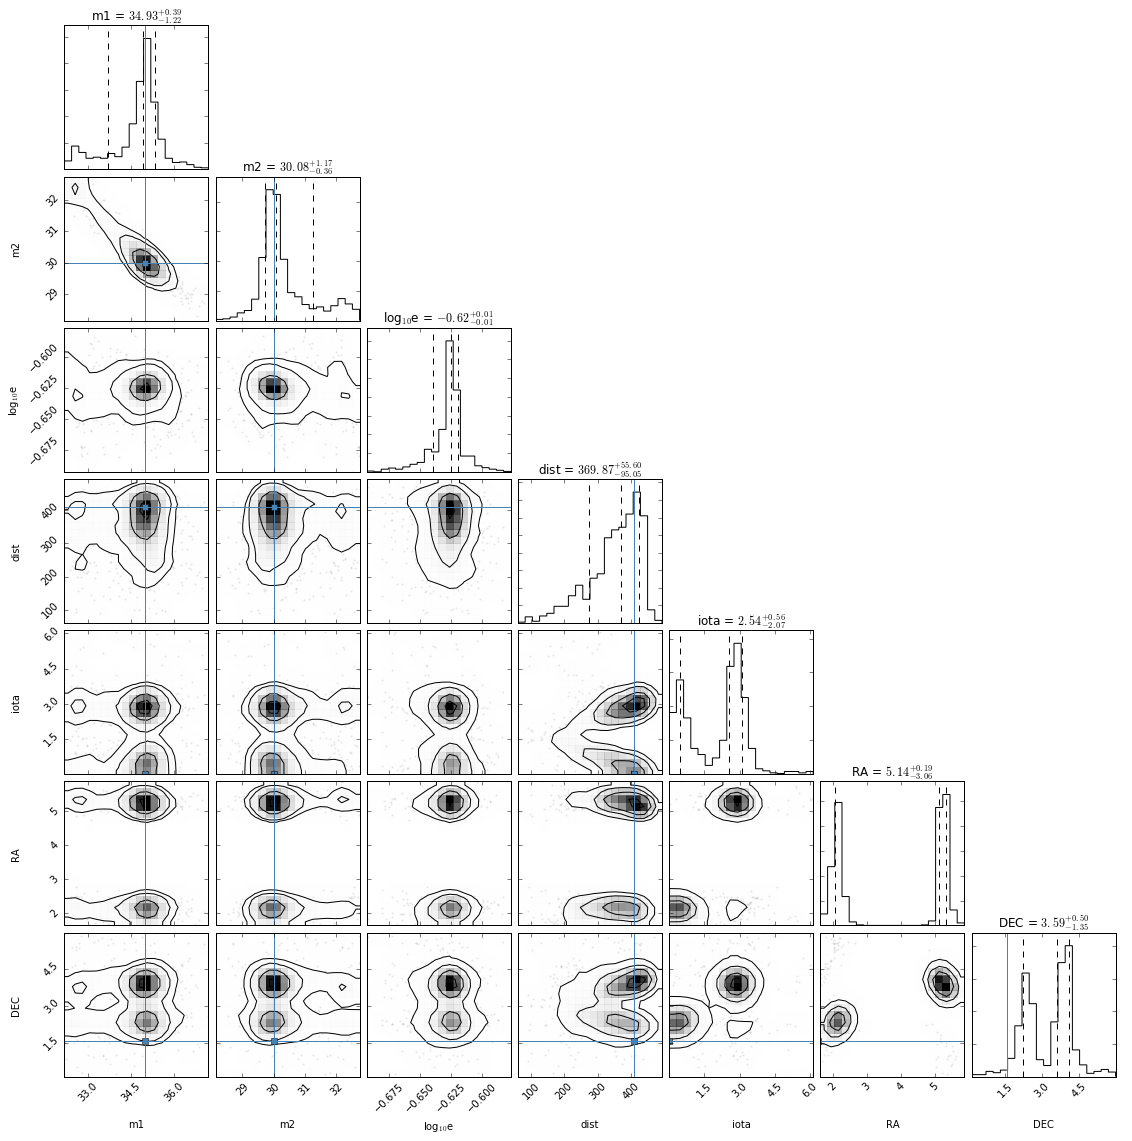

In [49]:
samples = stack_p[:1000,:]

truths=[35.,30.,np.log10(0.1),410.,(0.*np.pi/180),(90*np.pi/180.),(90.*np.pi/180.)]
ranges=[(200.,800.),(200.,800.),(200.,700.),(100.,600.),(150.,250.),(100.,250.),(100.,250.)]
fig = corner.corner(samples,labels=['m1', 'm2', 'log$_{10}$e', 'dist', 'iota', 'RA', 'DEC'],smooth=1,show_titles=True,quantiles=[0.16, 0.5, 0.84], truths=truths)
#fig.savefig("posteriors/triangle_2.0.png",dpi=300)

In [50]:
fig.savefig("posteriors/triangle_2.0.png",dpi=300)